#  Прогнозирование заказов такси

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

SEED = 42

## Подготовка

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

В таблице `taxi.csv` всего два признака - дата и время (часы и минуты) и количество заказов в определенное время. Прогноз на следующий час можно сделать только сгруппировав заказы за каждый час.

In [3]:
data = data.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

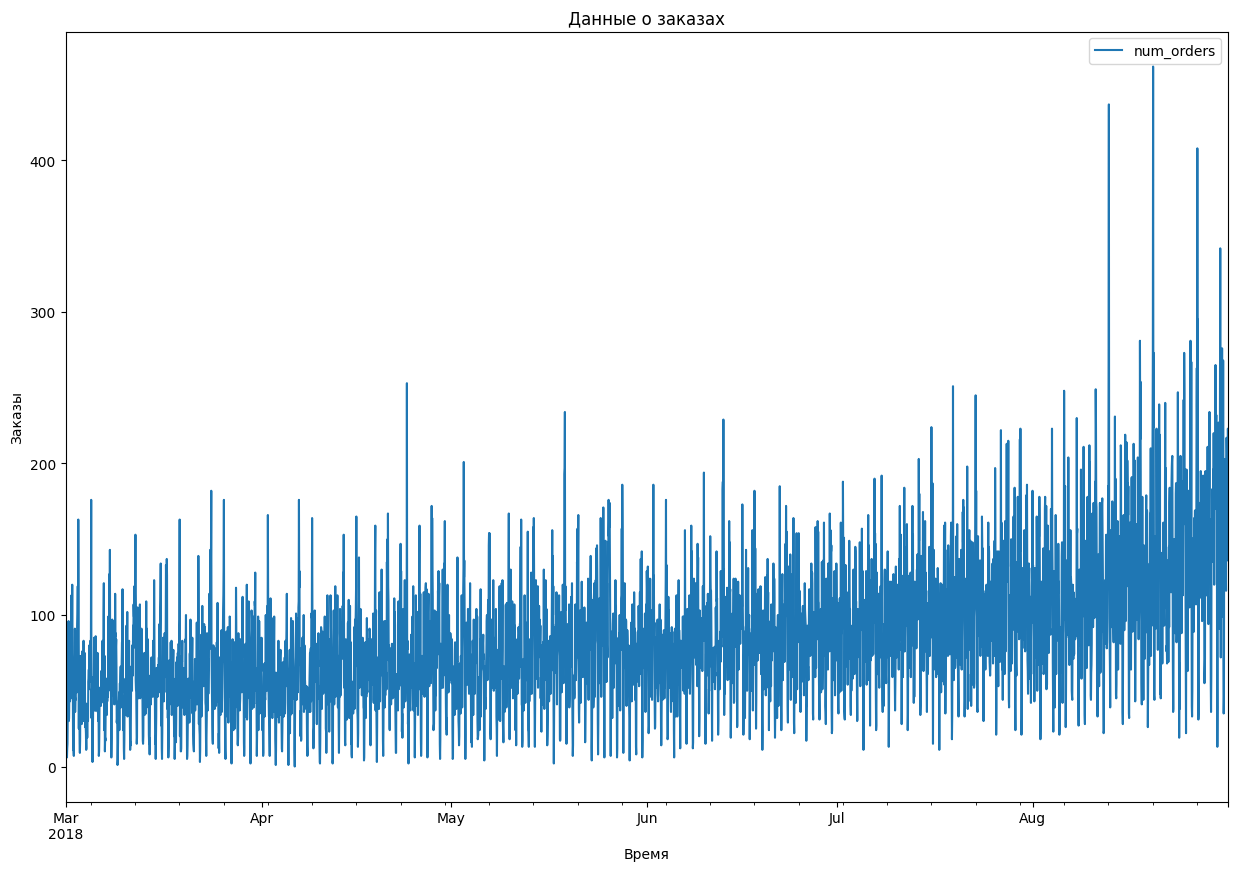

In [4]:
display(data.head())
display(data.info())
data.plot(title='Данные о заказах', xlabel='Время', ylabel='Заказы');
plt.show()

После ресемплирования в данных осталось 4416 записей. Самые ранние записи сделаны 1 марта 2018 года, самые старые 31 августа.

## Анализ

Данные есть только за несколько месяцев одного года - оценить, как время года влияет на количество клиентов, не получится. Кроме самих часов можно изучить, как на заказы влияет день и день недели.

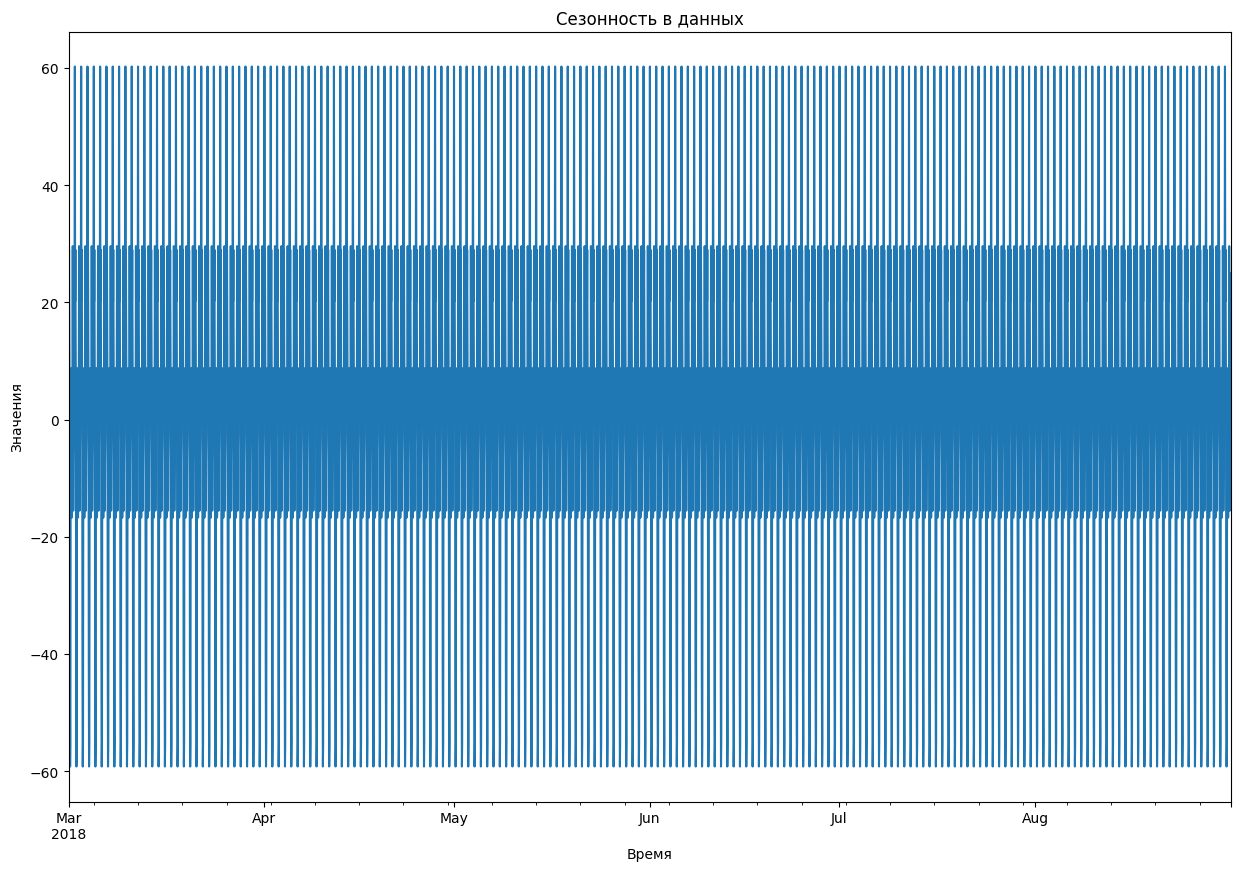

In [5]:
seasonal_decompose(data).seasonal.plot(title='Сезонность в данных', xlabel='Время', ylabel='Значения');

На графике сезонности, построенном на всех данных, видно, что сезон, или циклично повторяющаяся закономерность, гораздо меньше месяца. Может, эта закономерность длиной в неделю?

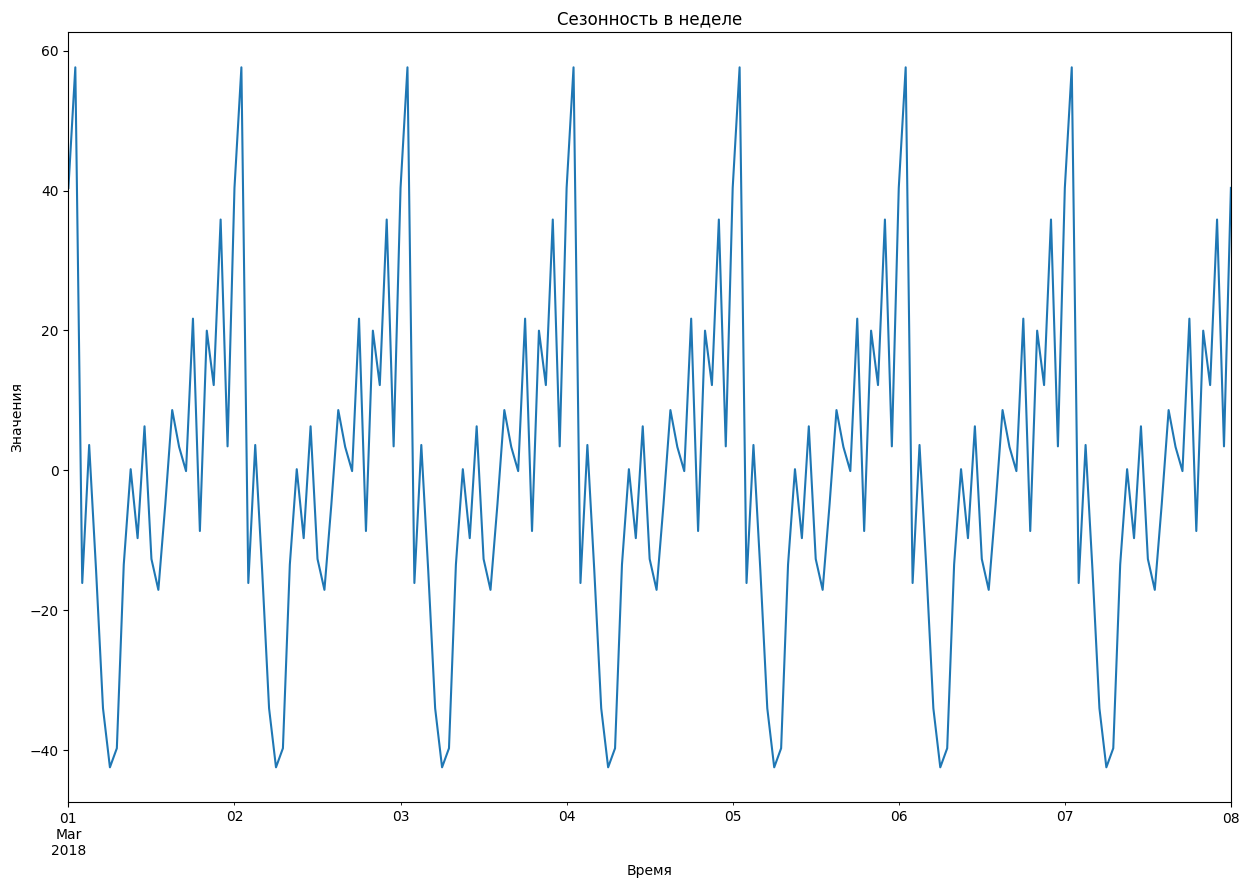

In [6]:
seasonal_decompose(data[:24*7+1]).seasonal.plot(title='Сезонность в неделе', xlabel='Время', ylabel='Значения');

Количество заказов колеблется в рамках одного дня, каждый день повторяя одну фигуру на графике.

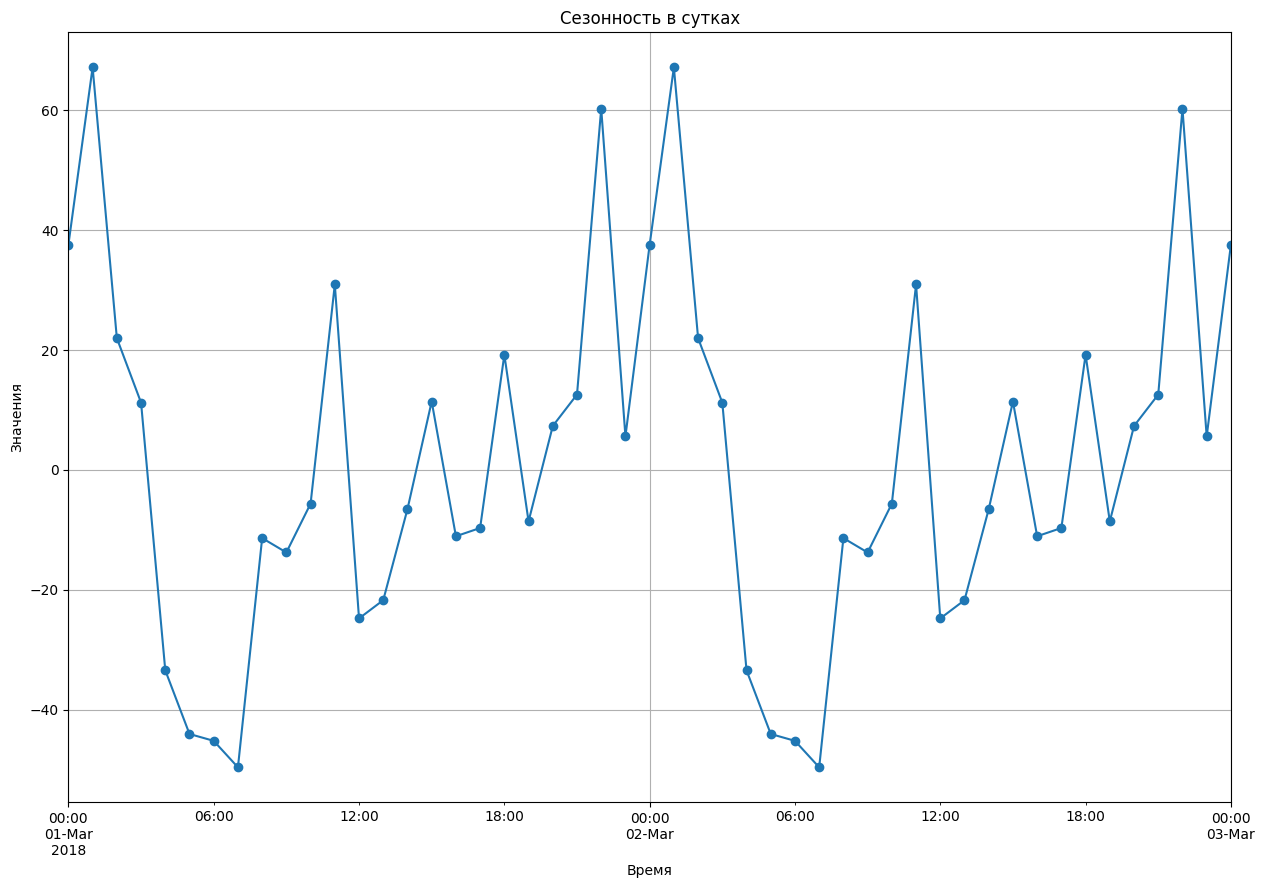

In [7]:
seasonal_decompose(data[:48+1]).seasonal.plot(title='Сезонность в сутках', xlabel='Время', ylabel='Значения', grid=True, style='o-');

На графике в ячейке выше видно, как количество заказов колеблется в течении двух суток. Пик заказов такси приходится на час ночи и после него заказы резко падают - к четырем утра заказов значительно меньше, а в 7 утра заказов меньше всего. Также много заказов бывает в 10 вечера. Есть и локальный пик в 11 утра, со значительно меньшим количеством заказов пару часов до и после него.

In [8]:
data['day'] = data.index.day
data['weekday'] = data.index.dayofweek
data['hour'] = data.index.hour

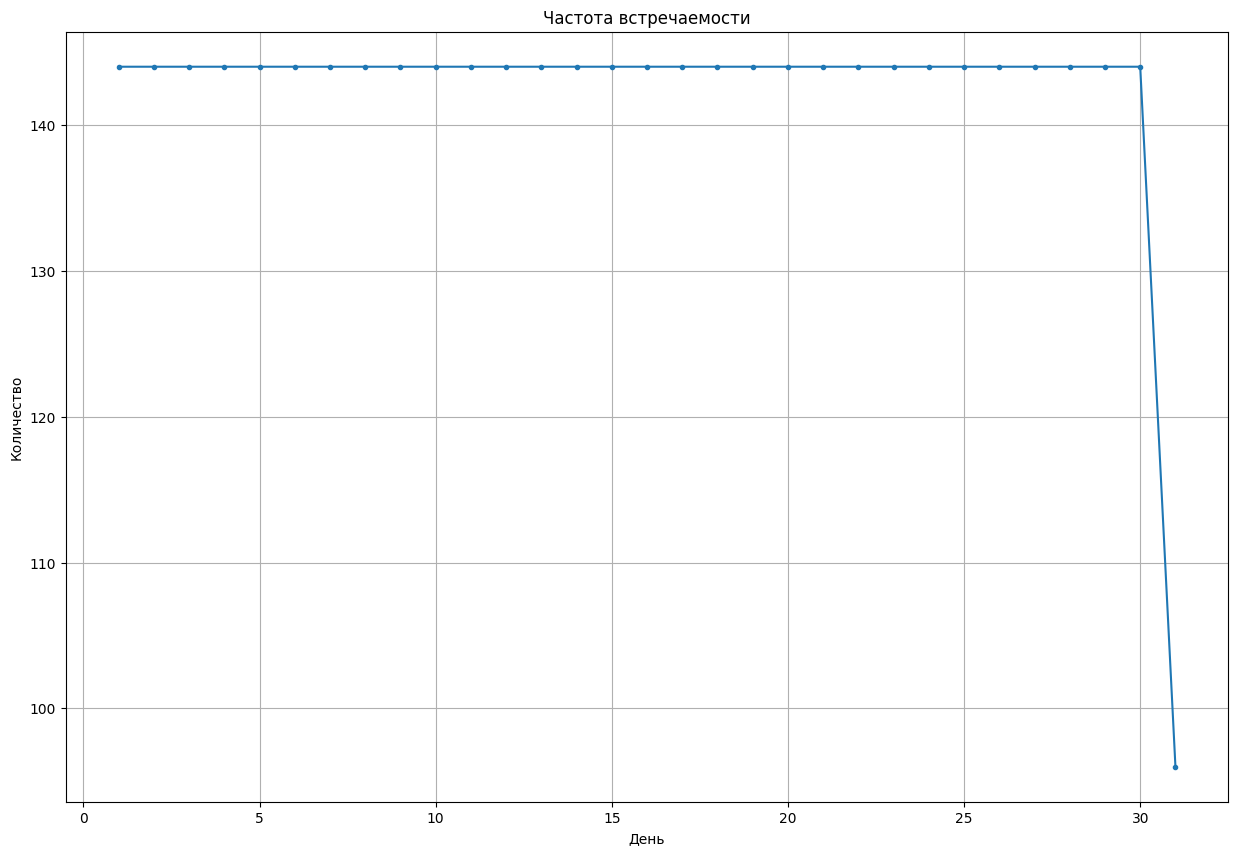

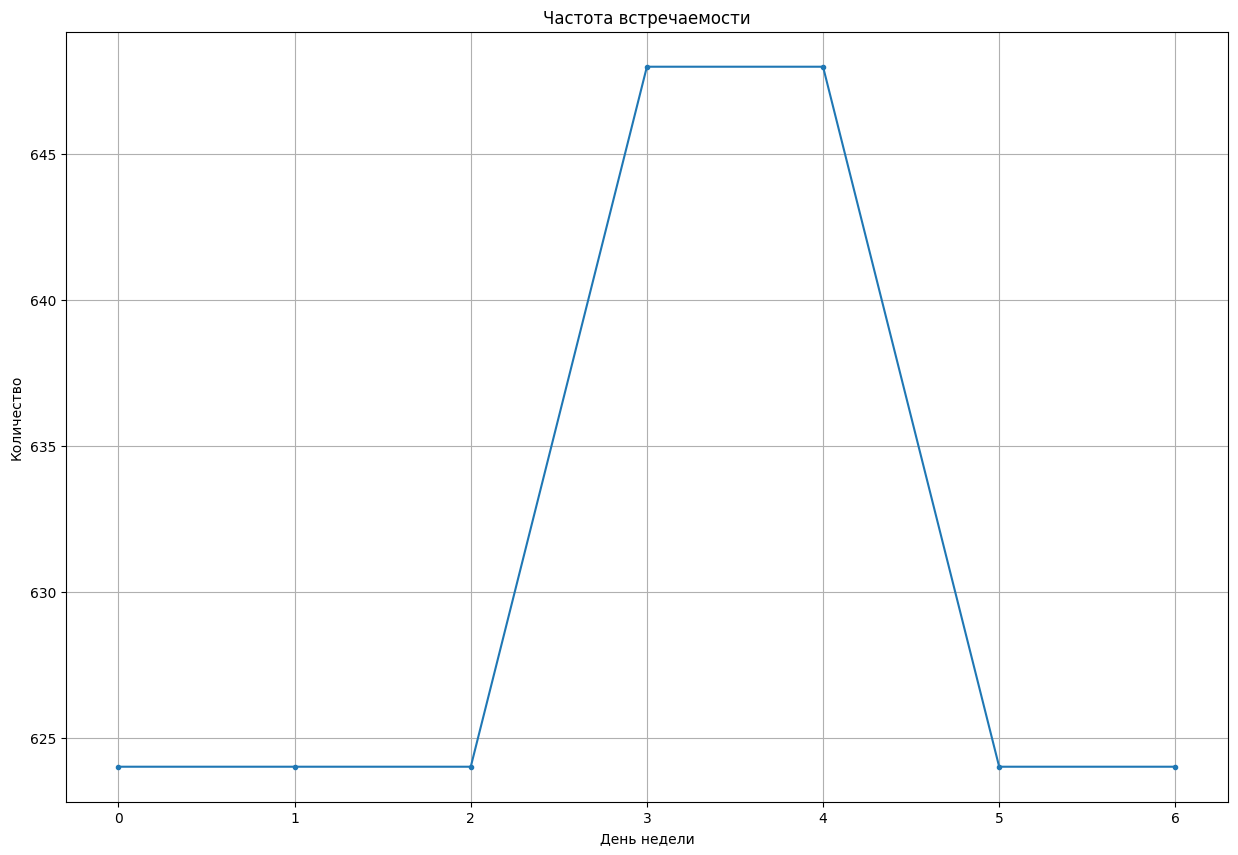

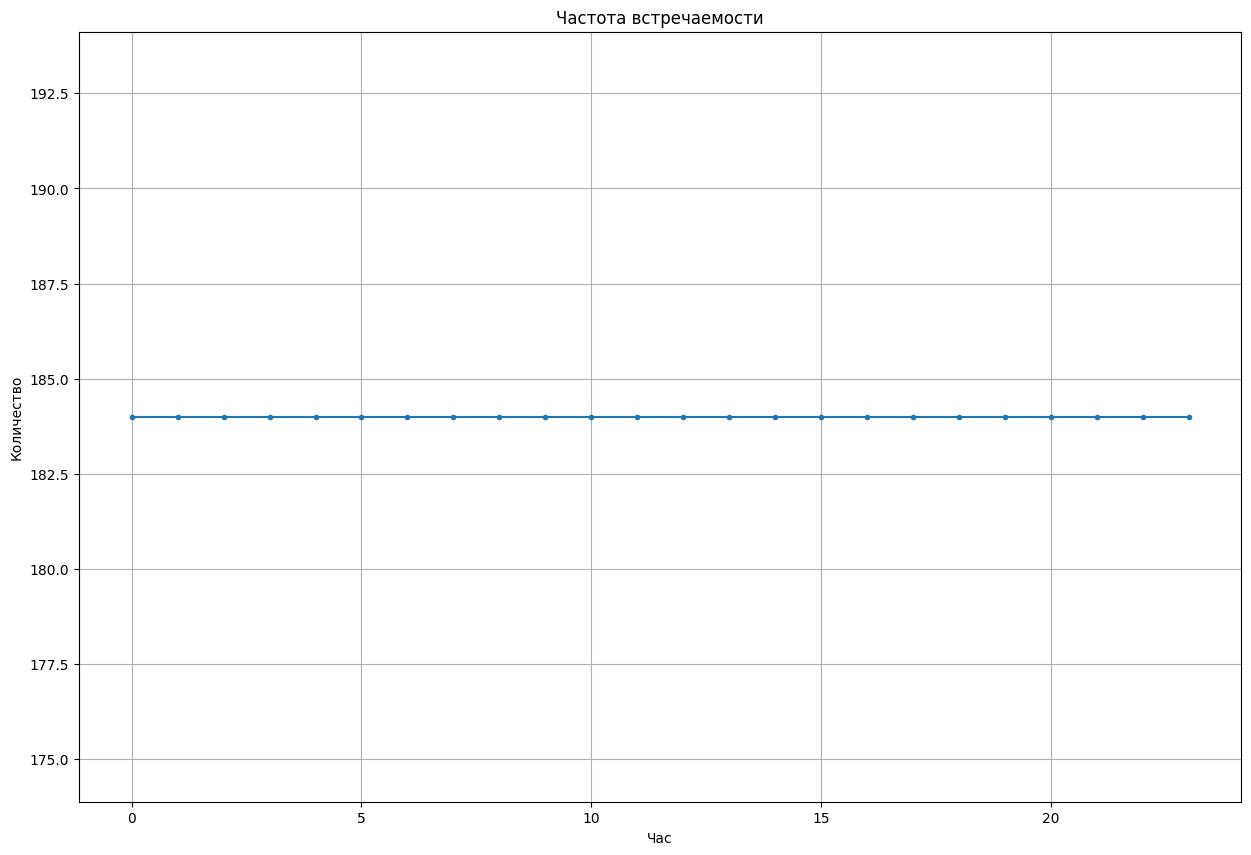

In [9]:
for n in [('day', 'День'), ('weekday', 'День недели'), ('hour', 'Час')]:
    pd.pivot_table(data, values='num_orders', index=n[0], aggfunc='count')\
      .plot(title='Частота встречаемости', xlabel=n[1], ylabel='Количество', legend='', style='.-', grid=True);

В данных одинаковое количество записей с разными часами. Календарных дней также одинаковое количество, если не считать 31 число, а четвергов и пятниц в выборку попало чуть больше остальных дней.

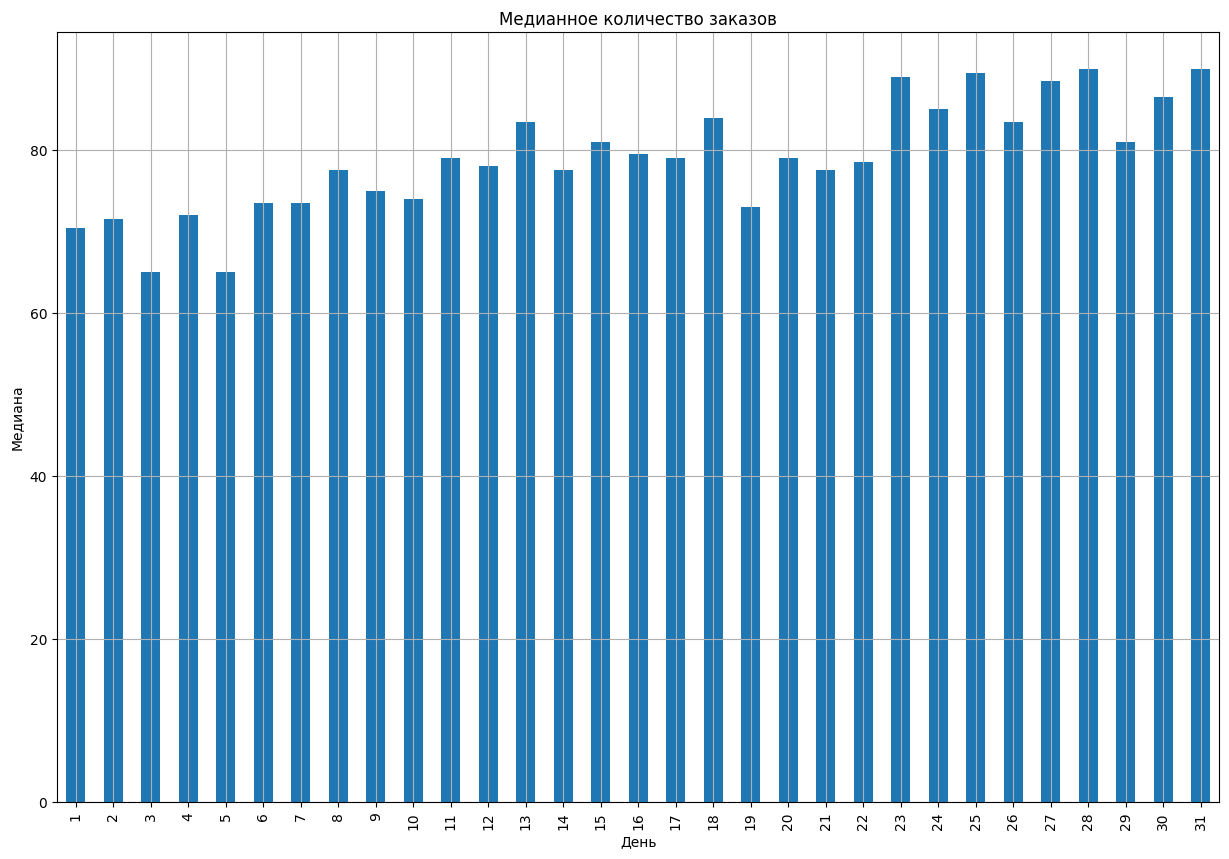

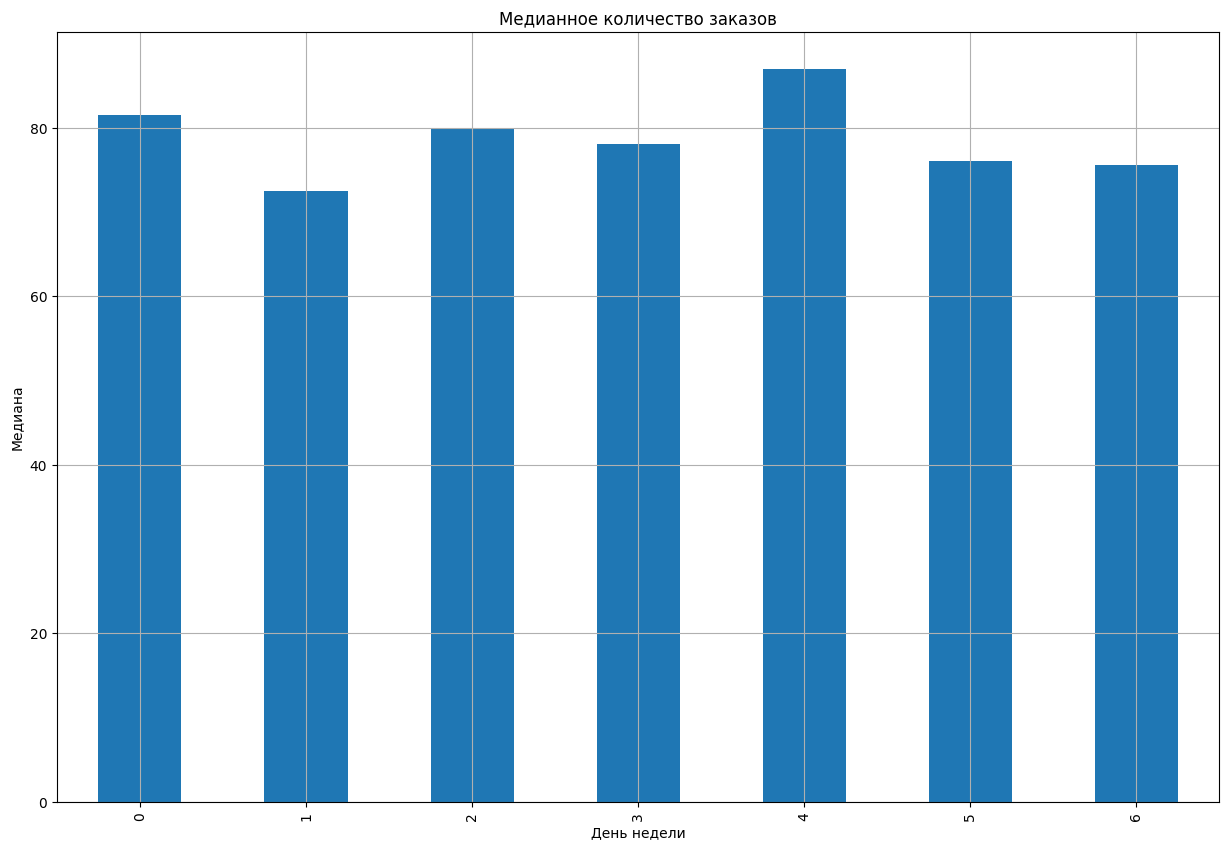

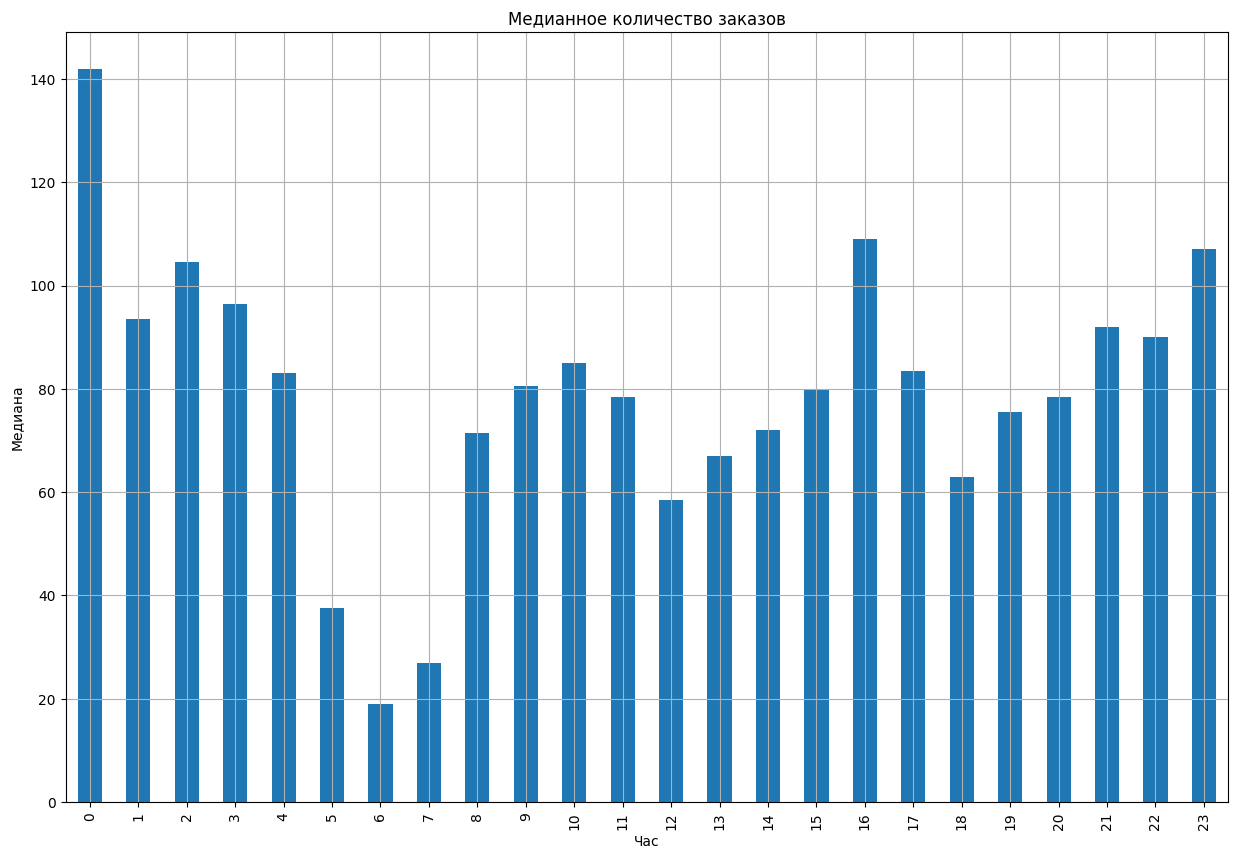

In [10]:
for n in [('day', 'День'), ('weekday', 'День недели'), ('hour', 'Час')]:
    pd.pivot_table(data, values='num_orders', index=n[0], aggfunc='median')\
      .plot(kind='bar', title='Медианное количество заказов', xlabel=n[1], ylabel='Медиана', legend='', grid=True);

Медианное количество заказов растет в течении месяца - в начале в день бывает от 65 до 75 заказов, под конец месяца заказов в среднем бывает 90. В разные дни недели количество заказов отличается не так сильно - от 70 во вторник до 85 в пятницу. В разное время дня разница в заказах действительно большая: в 6 часов утра бывает в среднем всего 20 заказов, а в 12 ночи больше 140. Прямой зависимости вроде "чем позднее время, тем больше клиентов" нет. Количество заказов меняется волнообразно. На графике можно очертить три "волны": с 6:00 до 12:00, с 12:00 до 18:00 и, самая большая с пиком в полночь, с 18:00 до 6:00.

In [11]:
data['rolling_mean'] = data['num_orders'].shift().rolling(24*7).mean()

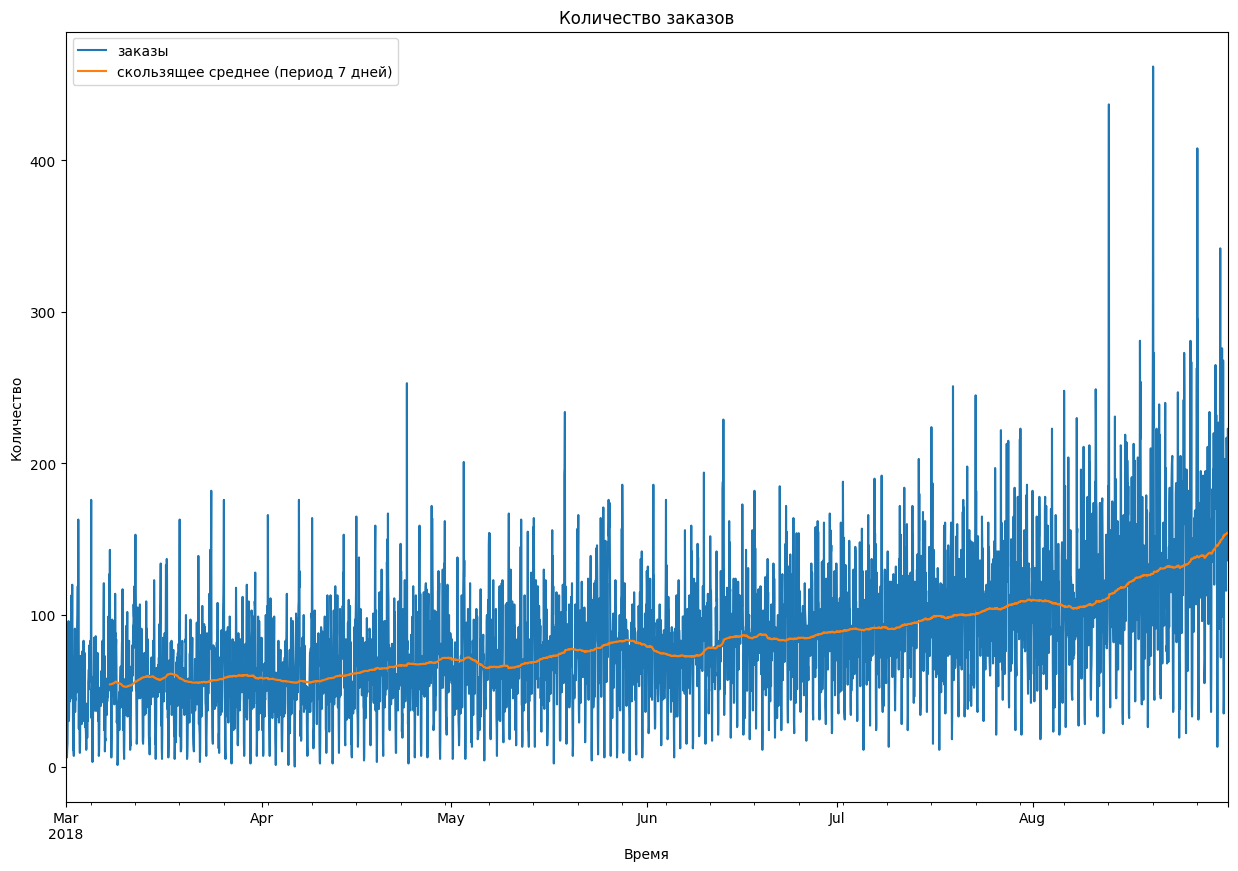

In [12]:
data.loc[:,('num_orders', 'rolling_mean')].plot(title='Количество заказов', xlabel='Время', ylabel='Количество')
plt.legend(('заказы', 'скользящее среднее (период 7 дней)'));

Количество заказов растет постоянно, почти с начала графика - рост заказов в течении месяца связан с общим ростом заказов, и совсем не с тем, что в конце месяца услуги такси требуются чаще.

Среднее скользящее здесь также растет со временем - это может означать, что временной ряд нестационарный, и в нем нет периодичности, на основе которой можно построить предсказания. Несмотря на то, что ранее мы выявили периодичное изменение количества заказов по часам, проверить весь ряд будет не лишним.

Проверить ряд на стационарность можно с помощью теста Дики-Фуллера - его реализация из модуля `statsmodels` расчитает наименьшее значение уровня значимости p-value и значения на уровнях значимости в 1, 5 и 10%. Нулевая гипотеза предполагает, что ряд нестационарный. Альтернативная - что ряд стационарный. Если p-value окажется больше значений значимости на 1% и 5%, то нулевая гипотеза подтвердится. Если p-value окажется меньше, то мы отклоним нулевую гипотезу в пользу альтернативной.

In [15]:
adf = adfuller(data['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % adf[0])
print('P-value: %f' % adf[1])
print('Значения на уровнях:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

Критерий ADF: -3.068924
P-value: 0.028940
Значения на уровнях:
	1%: -3.432
	5%: -2.862
	10%: -2.567


  
День сам по себе не влияет на количество заказов, его нужно исключить из признаков для обучения.

## Обучение

Перед обучением нужно создать тренировочную и тестовую выборки.

В признаках пока есть только день недели и час. Можно создать новые - количество заказов в предыдущие часы и их среднее количество за предыдущие несколько часов. Напишем функцию, которая создаст новые признаки:

In [14]:
def make_features(da, lags, rolling_sizes):
    df = da.copy()
    for lag in lags:
        df.loc[:, 'lag_{}'.format(lag)] = df.loc[:, 'num_orders'].shift(lag)
    for size in rolling_sizes:
        df.loc[:, 'rolling_mean_{}'.format(size)] =  df.loc[:, 'num_orders'].shift()\
          .rolling(size, min_periods=0).mean()
    return df.drop('num_orders', axis=1).fillna(-1)

In [15]:
train, test = train_test_split(data.drop(['day', 'rolling_mean'], axis=1),\
                               shuffle=False, test_size=0.1)

features_train = make_features(train, [1, 2, 24, 48, 72], [6, 12, 24, 48])
target_train = train['num_orders']
features_test = make_features(test, [1, 2, 24, 48, 72], [6, 12, 24, 48])
target_test = test['num_orders']

In [16]:
display(features_train.head(3))
display(features_test.tail(3))

,weekday,hour,lag_1,lag_2,lag_24,lag_48,lag_72,rolling_mean_6,rolling_mean_12,rolling_mean_24,rolling_mean_48
datetime,,,,,,,,,,,
2018-03-01 00:00:00,3,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2018-03-01 01:00:00,3,1,124.0,-1.0,-1.0,-1.0,-1.0,124.0,124.0,124.0,124.0
2018-03-01 02:00:00,3,2,85.0,124.0,-1.0,-1.0,-1.0,104.5,104.5,104.5,104.5


,weekday,hour,lag_1,lag_2,lag_24,lag_48,lag_72,rolling_mean_6,rolling_mean_12,rolling_mean_24,rolling_mean_48
datetime,,,,,,,,,,,
2018-08-31 21:00:00,4,21,154.0,136.0,198.0,170.0,189.0,171.166667,168.583333,168.041667,169.437500
2018-08-31 22:00:00,4,22,159.0,154.0,158.0,177.0,160.0,178.333333,164.916667,166.416667,169.208333
2018-08-31 23:00:00,4,23,223.0,159.0,246.0,265.0,179.0,182.666667,167.583333,169.125000,170.166667


В выборках добавилось 9 признаков: сколько было заказов 1, 2, 24, 48 и 72 часа назад, а также сколько в среднем было заказов за предыдущие 6, 12, 24 и 48 часов.

Теперь можно начать обучение.

In [17]:
num_features = features_train.columns

Все признаки числовые - чтобы модель могла хорошо на них обучиться, их нужно масштабировать. Напишем функкцию, которая проведет масштабирование, кросс-валидацию и подбор гиперпараметров модели:

In [18]:
def pipe_validate(model, param_grid, X_train, y_train, num_features=num_features):
    pipe = make_pipeline(StandardScaler(),
                         model)
    search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                          scoring='neg_mean_squared_error', verbose=1)
    search.fit(X_train, y_train)
    
    print(f'best_score: {np.sqrt(search.best_score_*-1)}')
    print(f'best_params: {search.best_params_}')
    return search

На вход функция получает модель, список гиперпараметров и тренировочную выборку, возвращает результаты обучения. Метрика для оценки качества модели на кросс-валидации - RMSE.     
Для решения задачи попробуем обучить несколько моделей. Результаты обучения занесем в список `stat_table`.

In [19]:
stat_table = []

<hr style='height:2px; background-color: #88BCE8; margin-bottom: 0' />

In [20]:
%%time
model = LinearRegression()
param_grid = {}
linreg = pipe_validate(model, param_grid, features_train, target_train)

stat_table.append(['LinearRegression', np.sqrt(linreg.best_score_*-1),\
                   linreg.cv_results_['mean_fit_time'][linreg.best_index_]])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best_score: 24.75815933491805
best_params: {}
CPU times: total: 0 ns
Wall time: 40.6 ms


Первая модель - линейная регрессия. Это одна из самых простых моделей, у нее нет гиперпараметров для настройки и обычно она хорошо справляется только с линейными зависимостями. Ее RMSE на валидации равнa 24.7 - хотя это уже неплохой результат, его возможно получится улучшить, просто взяв модель посложнее.

<hr style='height:2px; background-color: #88BCE8; margin-bottom: 0' />

In [21]:
%%time
model = KNeighborsRegressor()
param_grid = {'kneighborsregressor__n_neighbors': (3, 6, 9, 12),
              'kneighborsregressor__weights': ('uniform', 'distance'), 
              'kneighborsregressor__leaf_size' : (10, 20, 30, 40)}
kn = pipe_validate(model, param_grid, features_train, target_train)

stat_table.append(['KNeighborsRegressor', np.sqrt(kn.best_score_*-1),\
                   kn.cv_results_['mean_fit_time'][kn.best_index_]])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
best_score: 25.017273319096653
best_params: {'kneighborsregressor__leaf_size': 10, 'kneighborsregressor__n_neighbors': 12, 'kneighborsregressor__weights': 'distance'}
CPU times: total: 4.38 s
Wall time: 4.4 s


Вторая модель - регрессия методом k-ближайших соседей. В отличие от предыдущей модели, эта хорошо справляется и с нелинейными зависимостями. 
Для предсказания она ищет близкие по значению признаков семплы и вычисляет среднее их целевого признака.          
Качество этой модели на валидации чуть хуже - ошибка равна 25.

<hr style='height:2px; background-color: #88BCE8; margin-bottom: 0' />

In [22]:
%%time
model = RandomForestRegressor(random_state=SEED)
param_grid = {'randomforestregressor__n_estimators': (10, 20, 40, 60),
              'randomforestregressor__max_depth': (3, 6, 9, 12),
              'randomforestregressor__min_samples_split': (2, 4)}
forest = pipe_validate(model, param_grid, features_train, target_train)

stat_table.append(['RandomForestRegressor', np.sqrt(forest.best_score_*-1),\
                   forest.cv_results_['mean_fit_time'][forest.best_index_]])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
best_score: 24.312233684999967
best_params: {'randomforestregressor__max_depth': 9, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 60}
CPU times: total: 1min 28s
Wall time: 1min 38s


Следующая модель - случайный лес. У нее много гиперпараметров, и их подбор может занимать большое количество времени.      
RMSE лучшей модели леса равна 24.3, что лучше предыдущих моделей.

<hr style='height:2px; background-color: #88BCE8; margin-bottom: 0' />

In [23]:
%%time
model = AdaBoostRegressor(random_state=SEED)
param_grid = {'adaboostregressor__n_estimators' : (10, 25, 50, 75, 100),
              'adaboostregressor__learning_rate' : (0.1, 0.25, 0.5, 1)}
ada = pipe_validate(model, param_grid, features_train, target_train)

stat_table.append(['AdaBoostRegressor', np.sqrt(ada.best_score_*-1),\
                   ada.cv_results_['mean_fit_time'][ada.best_index_]])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best_score: 25.809025395409446
best_params: {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 100}
CPU times: total: 29 s
Wall time: 31.4 s


И последняя модель - AdaBoost регрессор. Это ансамбль из деревьев решений (или любых других моделей), который обучается с помощью бустинга: на каждой итерации ансамбль обучается на данных, делает предсказания и вычисляет веса на основе ошибки, затем эти веса применяются к данным, чтобы слабые модели снова могли на них обучиться.        
Ошибка этой модели на валидации равна 25.8. 

<hr style='height:2px; background-color: #88BCE8; margin-bottom: 0' />

In [24]:
pd.DataFrame(stat_table, columns=['model', 'RMSE', 'fit time'])

,model,RMSE,fit time
0,LinearRegression,24.758159,0.005484
1,KNeighborsRegressor,25.017273,0.006250
2,RandomForestRegressor,24.312234,1.331564
3,AdaBoostRegressor,25.809025,0.646901


В таблице с результатами собраны значения RMSE и времени обучения моделей. Самым медленным - в 300 раз медленнее линейной регресии - оказался случайный лес: на обучение ушло больше секунды. Зато в предсказаниях он был точнее - в среднем он ошибался на 24.3 заказа. Остальные модели, правда, ошибались всего на 1 заказ больше.

## Тестирование

Лучший результат показал случайный лес. Проверим его на тестовой выборке:

In [25]:
model = forest.best_estimator_
model.fit(features_train, target_train)
print("RMSE тестовой выборки:",  np.sqrt(mean_squared_error(target_test,
                                                            model.predict(features_test))))

RMSE тестовой выборки: 46.1515224357763


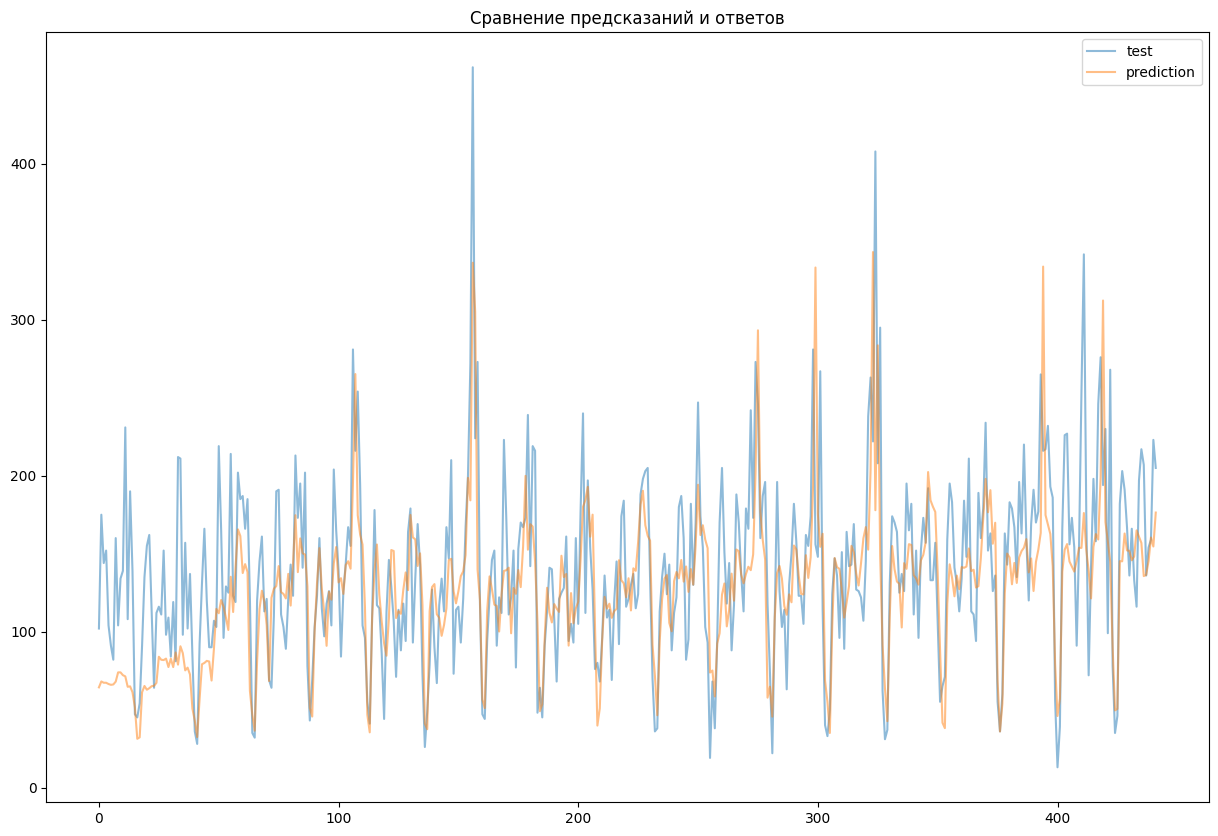

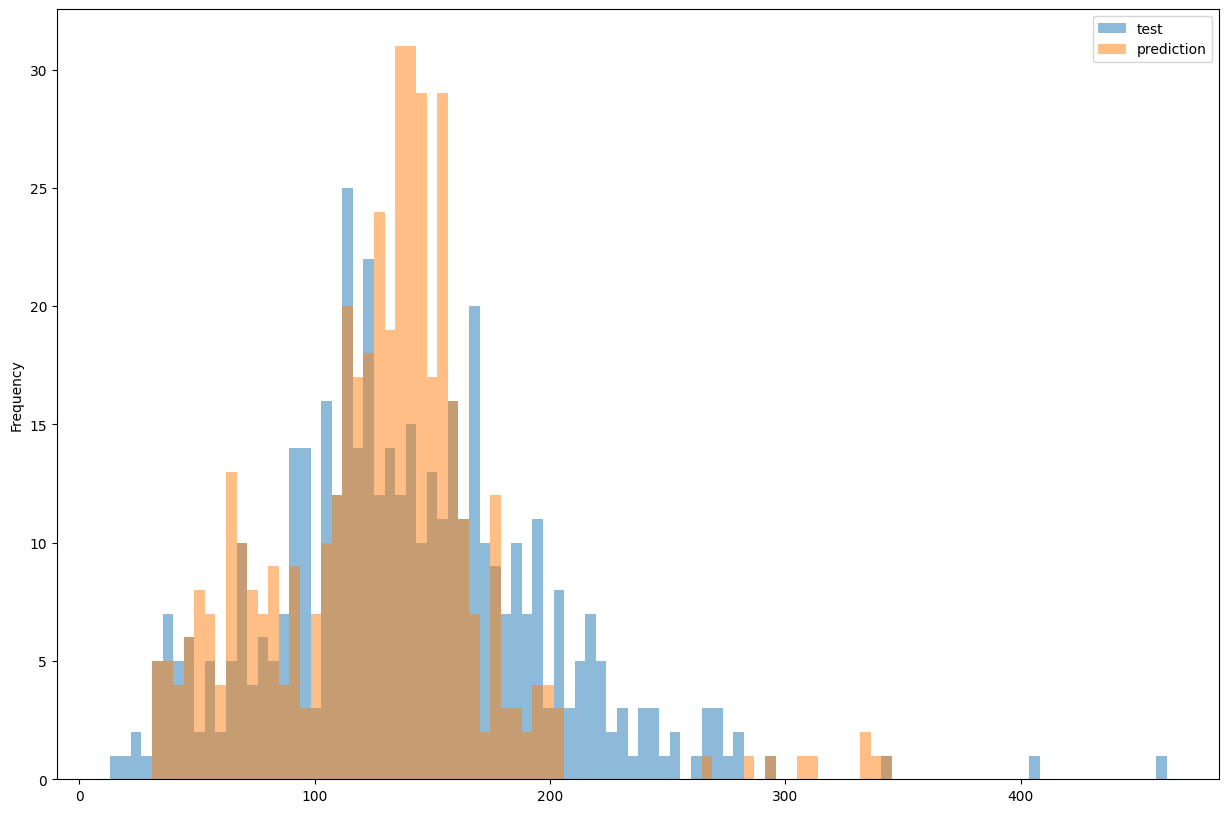

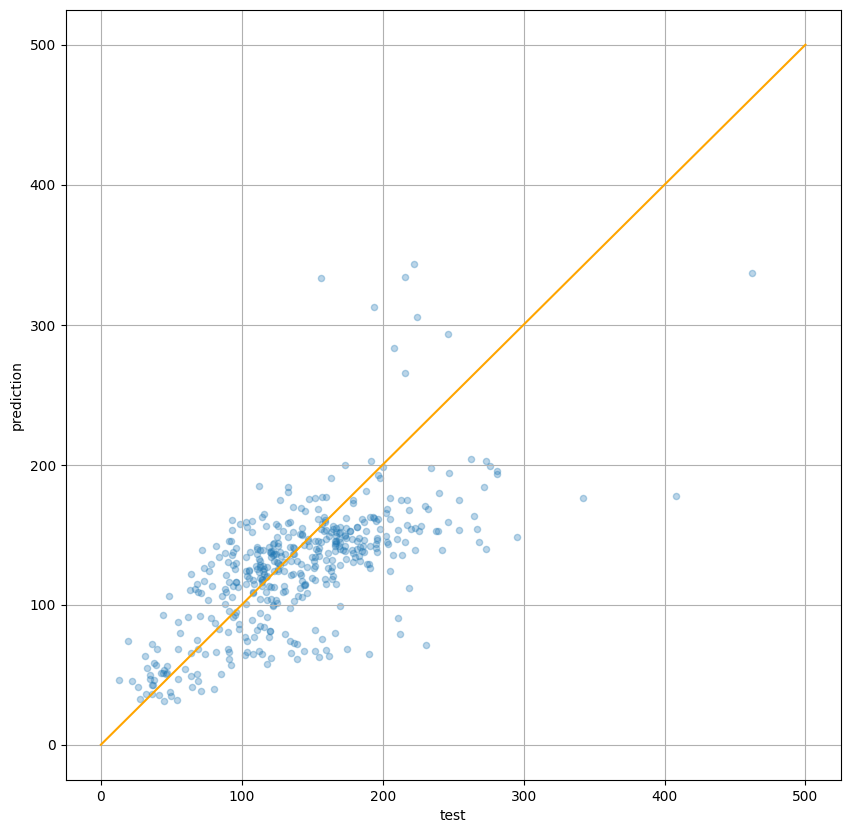

In [26]:
testdata = pd.DataFrame([target_test.values, model.predict(features_test)], index=['test', 'prediction']).T
testdata.plot(alpha=0.5, title='Сравнение предсказаний и ответов', x='test', y='prediction', );
testdata.plot(kind='hist', bins=100, alpha=0.5);
testdata.plot(kind='scatter', x='test', y='prediction', alpha=0.3, figsize=(10, 10), grid=True);
plt.plot([0, 500], [0, 500], color='orange');

In [27]:
for n in range(len(model.feature_names_in_)):
    print(model.feature_names_in_[n], ':', model.steps[1][1].feature_importances_[n])

weekday : 0.010093300360494264
hour : 0.05291438167497826
lag_1 : 0.060068377100834985
lag_2 : 0.02606308593765308
lag_24 : 0.13416723255184443
lag_48 : 0.40887716159296256
lag_72 : 0.16989640272268766
rolling_mean_6 : 0.06448295183352928
rolling_mean_12 : 0.035441523331638455
rolling_mean_24 : 0.01907888614184856
rolling_mean_48 : 0.018916696751528406


RMSE на тесте равна 46.15. Как видно на первом графике сравнения предсказаний и ответов, в начале тестовой выборки предсказания были очень неточными. Дальше они становятся точнее, хотя в пиках модель все еще ошибается. На остальных графиках также видны ошибки, но общий тренд модель все же нашла. Она неплохо предсказывает значения до 130, но неохотно предсказывает от 200 до 300, чаще недооценивая количество заказов и предсказывая на 50-100 меньше. Преувеличивает значения она не так часто и не так много - в основном меньше чем на 50 заказов. Есть маленькая группа преувеличенно предсказанных значений, где вместо 200-250 вышло 300-350 клиентов, но это снова произошло в проблемном диапазоне. Может, раз количество заказов со временем увеличивается, более свежие данные помогли бы точнее предсказывать большие значения.         
Самыми важными признаками для модели стали среднее количество за предыдущие 6 часов и количество заказов в тот же час 1, 2 и 3 дня назад. День недели меньше всего влияет на количество клиентов - по анализу сильного влияния тоже не было видно. Также для модели оказалось не сильно важно сколько заказов было несколько часов назад, или сколько их было в среднем за предыдущие несколько дней. Сам по себе час неожиданно слабо влияет на заказы - это может быть связано с тем, что в целом количество заказов растет каждый день, и более старые данные перестают отражать действительность; поэтому модели важны данные о заказах в определенный час за ближайшие несколько дней. Возможно стоит рассмотреть количество заказов не за три дня, а за всю прошлую неделю.

В итоге модель с достаточной точностью найдена - это модель случайного леса из 60 деревьев глубиной 9.